Hunter S. DiCicco

with Dr. Dongwon Lee, Ph.D.

# Multinomial SVC for Categories of News

## Diagnostics to Assess Model Performance

## TODO:
* Setup perplexity selection
* Finalize average recall over all labels and per-class recall (which is more challenging) (?????????)

### Setup and Imports

In [1]:
import pickle
import glob
import copy
import pdb
import sys
import os

from itertools import combinations
from functools import partial

from sklearn.model_selection import KFold
from sklearn.metrics import recall_score
from sklearn.svm import SVC

from MulticoreTSNE import MulticoreTSNE as TSNE

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

os.chdir("../")

from validator import validate

def main():
    """
    Instead of an import, we wrap the execution of both of these vital modules within `exec`.
    This ensures that changes are enacted on every chunk evaluation.
    """
    exec(open("classifier.py").read(), globals())
    exec(open("validator.py").read(), globals())

main()
random_state = 4261998

Retrieving data...
Retrieving data...
Retrieving data...
Retrieving data...
------------
recall:[0.7  0.88 0.03 0.29 0.89]
precision:[0.82 0.84 0.54 0.23 0.51]
f1:[0.75 0.86 0.06 0.26 0.65]
------------

{1: 68, 2: 28, 3: 217, 5: 158, 7: 24}
This model got 55.8% correct || 625 out of 1120.
False negatives for real data (1)
{5: 55, 2: 13}
False negatives for fake data (2)
{5: 28}
False negatives for opinion data (3)
{5: 144, 2: 8, 1: 12, 7: 53}
False negatives for polarized data (5)
{7: 139, 3: 4, 2: 15}
False negatives for satire data (7)
{1: 22, 3: 2}
Retrieving data...
Retrieving data...
Retrieving data...
Retrieving data...
------------
recall:[0.7  0.88 0.03 0.29 0.89]
precision:[0.82 0.84 0.54 0.23 0.51]
f1:[0.75 0.86 0.06 0.26 0.65]
------------

{1: 68, 2: 28, 3: 217, 5: 158, 7: 24}
This model got 55.8% correct || 625 out of 1120.
False negatives for real data (1)
{5: 55, 2: 13}
False negatives for fake data (2)
{5: 28}
False negatives for opinion data (3)
{5: 144, 2: 8, 1: 12, 

In [2]:
CLASS_DICT = dict(zip(('real', 'fake', 'opinion', 'polarized', 'satire', 'promotional', 'correction'),
                      (1, 2, 3, 5, 7, 9, 11)))

def load_latest_model(kernel=''):
    """
    Loads and returns the latest model from the `models` directory with the user-specified kernel.
    """
    #cwd = os.getcwd()
    # obtain a glob of the files in the `models` directory
    list_of_files = glob.glob(f"models/*{kernel}*.pickle")

    # obtain the model which was created most recently
    # using the sorting key of creation time
    latest_model = max(list_of_files, key=os.path.getctime)

    # open the most recent model and load it into the namespace
    # WARNING: only load pickle files that you trust!
    with open(latest_model, mode="rb") as filein:
        model = pickle.load(filein)
    return model

def cross_val_best(x, y, kf=None, kernel='rbf'):
    global random_state

    kf = kf if kf else KFold(n_splits=20, shuffle=True, random_state=random_state)
    splits = kf.split(x, y)

    models, recalls = {}, []

    ### report mean macro and micro average recall per fold
    for fold_i, (train, test) in enumerate(splits):
        x_train, y_train = x[train], y[train]
        x_test, y_test = x[test], y[test]
        model = SVC(C=2.075,
                    kernel=kernel,
                    gamma='scale',
                    random_state=random_state).fit(x_train, y_train)
        y_pred = model.predict(x_test)
        score = recall_score(y_test, y_pred, average='micro')
        recalls.append(recall_score(y_test, y_pred, average=None))
        models.update({model:score})
        validate(model, x_test, y_test);

    best_model = max(models, key=models.get)
    recalls = pd.DataFrame(recalls, columns=list(CLASS_DICT.keys()))

    print(f"Mean Class Recall Across {kf.n_splits!s} Folds: {*recalls.mean().round(4),!s}")
    return best_model


## Feature Selection

NOTES: *Some of the insights on linear feature importance used below obtained from [here](https://stackoverflow.com/a/22831491).*

*`plot_coefficients` method initially obtained from [here](https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d)*

In the next chunk we will use our models' support vectors to perform feature selection.

Each feature included in the SVM's training is assigned associated vector(s) of *weight coefficients* which encode that feature's influence on assigning class label(s) during inference. Specifically in the multinomial case, each feature will have many weight vectors since we use the one-versus-rest strategy to find one separating hyperplane per class.

The rows of the weight matrix describe the feature weights for each of the separation problems, which can be written as the mathematical combinations of each of the class labels with the others:

```
weights for 1 vs 2 hyperplane
weights for 1 vs 3 hyperplane
...
weights for 2 vs 3 hyperplane
weights for 2 vs 4 hyperplane
...
weights for 7 vs 11 hyperplane
weights for 9 vs 11 hyperplane
```

We can also compute the *vector norm* of each feature-weight vector to get a heuristic sense (**not** a direct measurement) of overall feature variance in the trained model. The greater a feature's empirical sample variance, the greater it will contribute to weight updates on each training epoch.

One final area of examination would be the model's trained *dual coefficients*, which are out of the author's scope and would require further research.

In summary we should prune those features which have near-zero contribution according to the weights, as well as those that have very little overall feature-weight variance.

Viewing the weight coefficients superimposed on each other in feature space as well as the overall feature-weight variances would give us a great idea as to which features contribute to which inference results. Let's build those visualizations now:

[use this to create a similar dual vis](https://cel.archives-ouvertes.fr/cel-01003007/file/Lecture2_Linear_SVM_Dual.pdf)

In [3]:
# list of features in use
features = ["url_ending_index", "from_reputable_source_index",
            "today_index", "grammar_index", "quotation_index",
            "past_tense_index", "present_tense_index", "should_index",
            "opinion_index", "all_caps_index", "from_satire_source_index",
            "exclamation_index", "apa_index", "name_source_index",
            "interjection_index", "you_index", "dot_gov_ending_index",
            "from_unreputable_source_index"]

data_with_vars = {}

read_with_params = partial(pd.read_csv,
                           delim_whitespace=True,
                           names=features)

for file in glob.glob('data\\*vectors*.txt'):
    data_with_vars[file.split('\\')[-1].split('.')[0]] = read_with_params(file)

for var, df in data_with_vars.items():
    df['label'] = CLASS_DICT[var.split('_')[0]]

d_full = pd.concat(data_with_vars.values(), ignore_index=True)
#dummy_labels = pd.get_dummies(d_full.label)
#dummy_labels.columns = list(CLASS_DICT.keys())
#d_full = d_full.drop('label', axis=1)
#d_full = pd.concat([d_full, dummy_labels], axis=1)

#fig, ax = plt.subplots(3, 6)
#for column in d_full.columns:
#    d_full[column].plot.density(ax=ax)

#d_full['label'].plot.density(ind=list(CLASS_DICT.values()))

In [4]:
x, y = *(d_full[d_full.columns.difference(['label'])],
         d_full['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

model = cross_val_best(x, y, kernel='linear', kf=KFold(n_splits=3, shuffle=True, random_state=random_state));

{}
This model got 100.0% correct || 5515 out of 5515.
{}
This model got 100.0% correct || 5514 out of 5514.
{}
This model got 100.0% correct || 5514 out of 5514.
Mean Class Recall Across 3 Folds: (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)


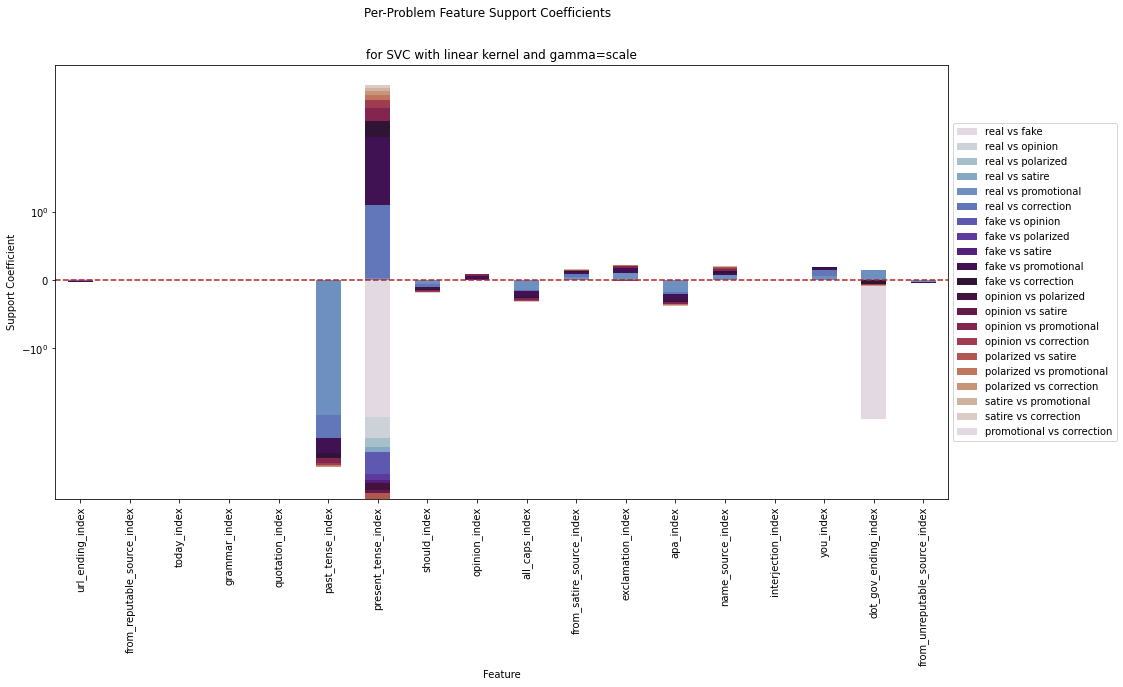

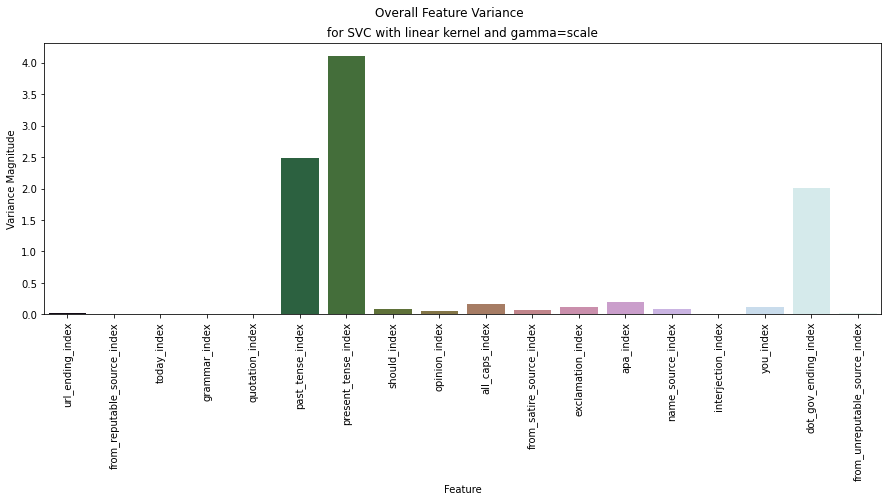

In [5]:
# load latest linear model
#model = load_latest_model(kernel='linear')

# we are only writing procedures for linear (done) and rbf (todo)
# linear has easy-to-interpret feature-weight calculations
# and rbf uses the dual coefficients, which are notoriously harder to interpret
if not model.kernel in ("linear", "rbf"):
    raise AttributeError('Initial model kernel is not linear or RBF. Only linear SVCs have primal coefficients for support weights.')

def plot_coefficients(classifier, feature_names):
    """
    Method Docstring Placeholder
    """
    #pdb.set_trace()
    global CLASS_DICT

    # extract class labels and #classes
    classes = list(CLASS_DICT.keys())
    n_classes = len(classes)

    # use itertools.combinations to create a list
    # of the pair combinations of class labels
    classes = list(combinations(classes, 2))

    # coerce the weight coefficient matrix to a pandas dataframe
    # for utility
    if classifier.kernel=='linear':
        coef = pd.DataFrame(classifier.coef_, columns=feature_names)
    else: 
        coef = pd.DataFrame(classifier.support_vectors_, columns=feature_names)
    # we must transpose `coef` to plot it in feature space
    ax = coef.T.plot(kind="bar",
                     stacked=True,
                     figsize=(16,8),
                     colormap="twilight",
                     title=f"for SVC with {classifier.kernel} kernel and gamma={classifier.gamma!s}",
                     logy='sym')

    # now we need a handle for the plot's legend
    # in order to correctly label the separation problems
    legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    # the i'th patch label in the legend
    # should contain the items of the combination pairs
    for i, label in enumerate(legend.get_texts()):
        label.set_text(f"{classes[i][0]!s} vs {classes[i][1]!s}")

    # a line at the origin to create a visual anchor
    plt.axhline(linestyle='dashed', color='firebrick')

    # setting axis labels, over-title and saving the figure
    ax.set(xlabel="Feature", ylabel="Support Coefficient")
    plt.suptitle("Per-Problem Feature Support Coefficients")
    plt.savefig("featureselection_1.png")
    return coef

coef = plot_coefficients(model, features)

# subset features with very low contributions
# in a list of features we should ablate
features_to_ablate = list(coef.mean()[coef.mean().abs()<1e-3].index)

# obtain the number of classes
# as well as weights for supports of each class
(n_classes, coefs) = *(len(model.classes_), model.coef_.transpose()),

# take the vector norm ([x dot x]^(1/2)) of each feature-weight vector (axis 1)
dot_coefs = np.apply_along_axis(lambda x: np.sqrt(x.dot(x)), 1, coefs)

### plotting
plt.figure(figsize=(15,5))

# using seaborn for utility
ax = sns.barplot(features,
                 dot_coefs,
                 palette=sns.color_palette("cubehelix", len(features)))

ax.set_title(f"for SVC with {model.kernel} kernel and gamma={model.gamma!s}")
plt.suptitle("Overall Feature Variance")
ax.set_xticklabels(features, rotation=90)
ax.set(xlabel='Feature', ylabel='Variance Magnitude')
plt.savefig("featureselection_2.png")
###

# each vector in the list below represents the support vectors for 
#coefs = model.dual_coef_

### Subset of Robust-Feature Data

#### Hand Selection Based on Visualization

In [6]:
# hand selection
d_subset_robust = d_full.drop(features_to_ablate, axis=1)

#y = d_full[list(CLASS_DICT.keys())].to_numpy()
#x = d_full[d_full.columns.difference(list(CLASS_DICT.keys()))].to_numpy()

# x: all but the label column
# y: only the label column
x, y = *(d_subset_robust[d_subset_robust.columns.difference(['label'])],
         d_subset_robust['label']),

x, y = map(lambda j: j.to_numpy(), (x,y))

best_model = cross_val_best(x, y)

with open(f"models/model_kernel[{best_model.kernel}]gamma[{best_model.gamma}]_subset.pickle", mode="wb") as fileout:
    pickle.dump(best_model, fileout)

{}
This model got 100.0% correct || 828 out of 828.
{}
This model got 100.0% correct || 828 out of 828.
{}
This model got 100.0% correct || 828 out of 828.
{}
This model got 100.0% correct || 827 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{9: 1, 7: 1}
This model got 99.76% correct || 825 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{7: 1}
This model got 99.88% correct || 826 out of 827.
{3: 1}
This model got 99.88% correct || 826 out of 827.
{9: 1}
This model got 99.88% correct || 826 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{3: 1}
This model got 99.88% correct || 826 out of 827.
{11: 1}
This model got 99.88% correct || 826 out of 827.
{3: 1}
This model got 99.88% correct || 826 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{}
This model got 100.0% correct || 827 out of 827.
{5: 1}
This model got 99.88% 

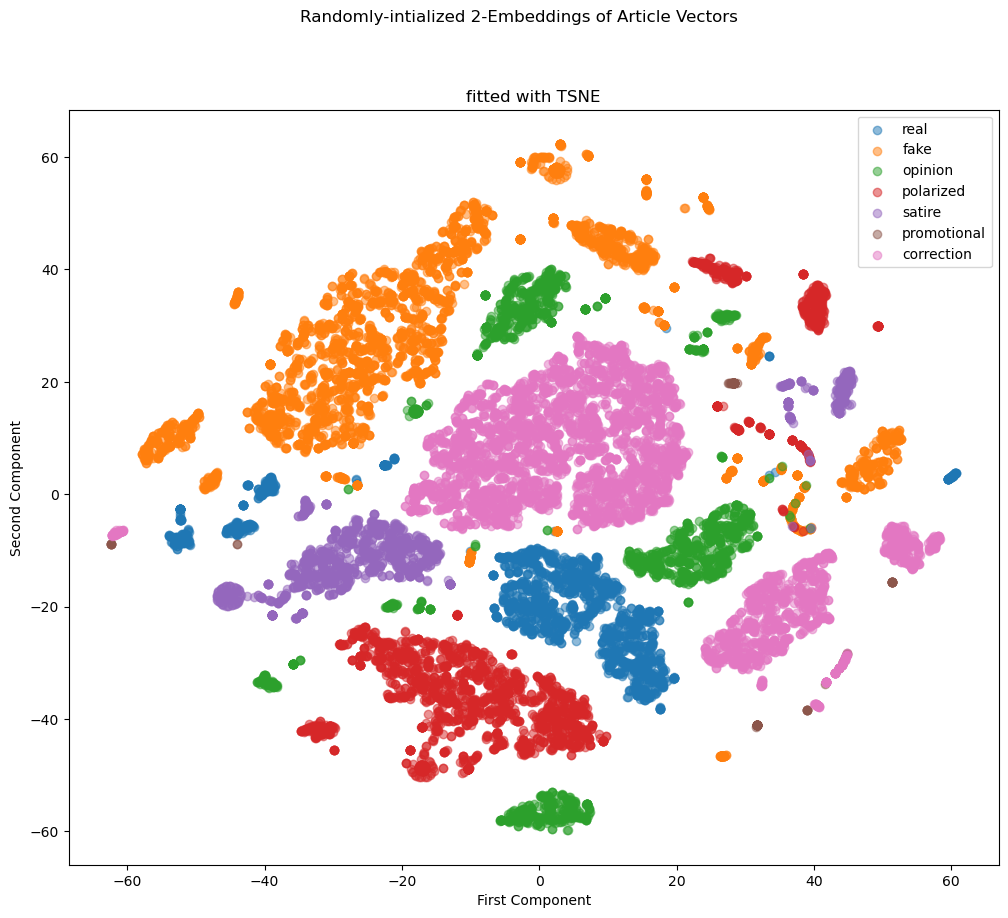

In [7]:
# fitting a TSNE manifold model is time-intensive, so we load a previous embedding if it exists.
list_of_files = glob.glob("./data/*TSNE*.pickle")
try:
    # open a premade fit
    latest = max(list_of_files, key=os.path.getctime)
    with open(latest, mode='rb') as filein:
        embedded = pickle.load(filein)
except (IOError, FileNotFoundError, ValueError):
    # fit on the fly
    ts = TSNE(init='random',
              random_state=random_state,
              verbose=1, # recall: all output --> stdout, so it will render in command line
              n_jobs=-1)
    embedded = ts.fit_transform(x)
    with open(f"./data/d-full_TSNE-2_init={ts.init}_perplexity={ts.perplexity!s}random_state={random_state!s}.pickle", mode='wb') as fileout:
        pickle.dump(embedded, fileout)

# convert to a dataframe if we stored the embeddings as an `ndarray`
if not isinstance(embedded, pd.DataFrame) and isinstance(embedded, np.ndarray):
    x, y = embedded[:,0], embedded[:,1]
    embedded = pd.DataFrame({'x':x, 'y':y, 'label':d_full['label']})

# we need a mapping of numeric label to string label
# in a moment we will use it to assemble the plot's legend

fig, ax = plt.subplots(figsize=(12,10), dpi=100)

for i, (classname, label) in enumerate(CLASS_DICT.items()):
    subset = embedded.query(f'label=={label!s}')
    x_subset, y_subset = subset['x'], subset['y']
    ax.scatter(x_subset, y_subset,
               label=classname,
               color="C"+str(i), alpha=0.5)

ax.legend()
plt.suptitle("Randomly-intialized 2-Embeddings of Article Vectors")
plt.title("fitted with TSNE")
plt.xlabel("First Component")
plt.ylabel("Second Component")
plt.savefig(f"./figures/TSNE-2_init=random_random_state={random_state!s}_classlabels.png", dpi=1000)